## Perceptrón multicapa

En esta parte de la práctica vamos a crear una red neuronal profunda, definiendo:
- la capa de entrada, 
- las capas ocultas, 
- una capa de dropout para mejorar los resultados y evitar overfitting 
- y, finalmente, la capa de salida.

Con la librería keras_tuner, vamos a optimizar la estructura de la red neural, ya que, vamos a seleccionar el número óptimo de neuronas, el número de capas ocultas y la cantidad de dropout a aplicar. Y todo ello de manera automática.

Vamos a analizar distintos métodos para realizar la optimización de los hiperparámetros con Hyperband.

En primer lugar realizamos las importaciones necesarias y cargando los sets de datos.

In [1]:
#!pip install keras_tuner
#!pip install tensorflow

In [2]:
# Importamos las librerías necesarias.
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split


In [3]:
# Importamos los datos de test, train y val.
X_train = pd.read_csv("./DatosAbandonoSinNanSub/X_train.csv", sep=',', decimal='.')
y_train = pd.read_csv("./DatosAbandonoSinNanSub/y_train.csv", sep=',', decimal='.')
#X_val = pd.read_csv("./DatosAbandonoSinPondSinNanSub/X_val.csv", sep=',', decimal='.')
#y_val = pd.read_csv("./DatosAbandonoSinPondSinNanSub/y_val.csv", sep=',', decimal='.')
X_test = pd.read_csv("./DatosAbandonoSinNanSub/X_test.csv", sep=',', decimal='.')
y_test = pd.read_csv("./DatosAbandonoSinNanSub/y_test.csv", sep=',', decimal='.')



In [4]:
y_train.head()

,DROPOUT_RISK
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [5]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
#scaler = preprocessing.Normalizer().fit(X_train)
X_train = scaler.transform(X_train)
#X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
y_train = y_train
#y_val = y_val
y_test = y_test


In [6]:
from tensorflow.keras.utils import to_categorical

In [7]:
# Pasamos a etiquetas one-hot encoded #(X)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
print(X_train)
print(y_train.shape)


[[-0.655481   -0.50057857  1.68779707 ...  0.71962116  0.1433565
   1.13656378]
 [-0.66192634 -0.08749392 -0.05437607 ...  0.97883191  0.59392761
   0.1795633 ]
 [-0.64971411 -0.77372394  0.96986858 ... -0.63944407 -0.52959182
   0.23645713]
 ...
 [-0.66803245 -0.61379333  1.04963841 ... -2.44409275 -2.04080592
  -2.54136067]
 [-0.28063349 -0.20404057  1.73884977 ...  1.38685566  0.10076498
   1.08987646]
 [ 0.35609845 -0.1780102   1.58250089 ...  0.75613524  0.2993673
  -0.13562086]]
(12153, 3)


In [9]:
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

Definimos la función que va a probar las distintas combinaciones de hyperparámetros que le indiquemos.
Esta función equivale a un GridSearch por fuerza bruta, donde probaremos varios valores de capas, número de neuronas, de dropout y learning rate.

Para facilitar el cómputo, sólo se ha implementado una capa 

In [10]:
def model_builder(hp):
    # Definición del modelo
    model = keras.Sequential()

    # Tuning del número de neuronas de las hidden layer
    hp_units = hp.Int('units', min_value=8, max_value=128, step=8)
    
    # Tuning del número de capas
    hp_layers = hp.Int('layers', min_value=1, max_value=5, step=1)
    
    # Input layer
    model.add(layers.Dense(units=128, activation='relu', input_shape=(X_test.shape[1],)))
    
    # Hidden layers 
    for i in range(hp_layers):
        # Añadimos la hidden layer
        model.add(layers.Dense(units=hp_units, activation='relu'))
        
    # Output layer
    model.add(layers.Dense(3, activation='softmax'))
    
    # Seleccionamos el valor optimo entre [0.01, 0.001, 0.0001]
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    
    model.compile(
        #optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), 
        optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [24]:
tuner = kt.Hyperband(
    model_builder,
    objective= 'val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hp_dir_sin',
    project_name='ruters_dataset_sin',
    overwrite = True
)

In [12]:
# Creamos una función de callback que limpie el output
import IPython
import tensorflow as tf

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [13]:
# Ejecución del proceso de tuning
tuner.search(
    X_train, 
    y_train,
    epochs=10,
    validation_split=0.2,
    callbacks=[ClearTrainingOutput()]
)

Trial 30 Complete [00h 00m 05s]
val_accuracy: 0.7647058963775635

Best val_accuracy So Far: 0.8054298758506775
Total elapsed time: 00h 01m 06s
INFO:tensorflow:Oracle triggered exit


In [14]:
# Obtención de los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Units:", best_hps.get('units'))
print("Layers:", best_hps.get('layers'))

Units: 120
Layers: 5


In [15]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    X_train,
    y_train,
    epochs = 20,
    validation_split = 0.2,
    shuffle = True
)

Epoch 1/20
304/304 [==============================] - 1s 2ms/step - loss: 1.0113 - accuracy: 0.5246 - val_loss: 0.9874 - val_accuracy: 0.6018
Epoch 2/20
304/304 [==============================] - 0s 1ms/step - loss: 0.9550 - accuracy: 0.5646 - val_loss: 0.8804 - val_accuracy: 0.6853
Epoch 3/20
304/304 [==============================] - 0s 1ms/step - loss: 0.9288 - accuracy: 0.5785 - val_loss: 1.0118 - val_accuracy: 0.5849
Epoch 4/20
304/304 [==============================] - 0s 1ms/step - loss: 0.9167 - accuracy: 0.5898 - val_loss: 0.7444 - val_accuracy: 0.7943
Epoch 5/20
304/304 [==============================] - 0s 1ms/step - loss: 0.9110 - accuracy: 0.5923 - val_loss: 0.9284 - val_accuracy: 0.6388
Epoch 6/20
304/304 [==============================] - 0s 1ms/step - loss: 0.9058 - accuracy: 0.5909 - val_loss: 0.7837 - val_accuracy: 0.7528
Epoch 7/20
304/304 [==============================] - 0s 1ms/step - loss: 0.9025 - accuracy: 0.5968 - val_loss: 0.8504 - val_accuracy: 0.6767
Epoch 

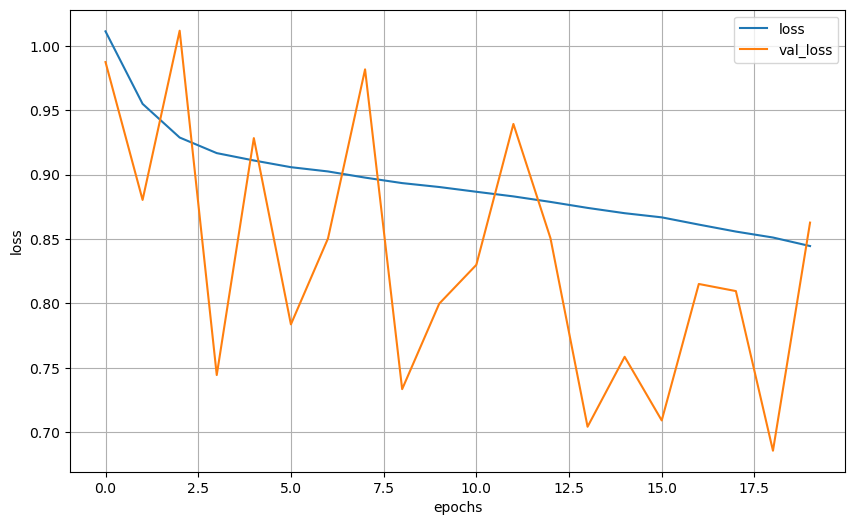

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

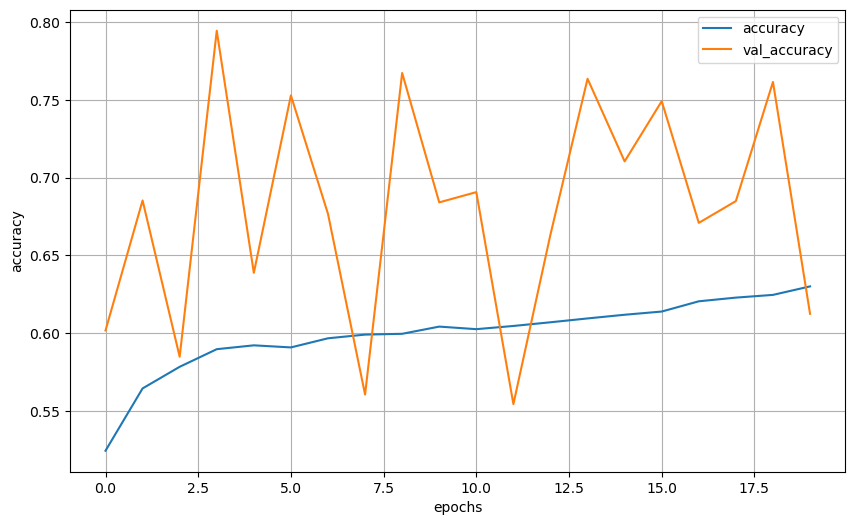

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [18]:
model.evaluate(X_test, y_test)

195/195 [==============================] - 0s 830us/step - loss: 1.0063 - accuracy: 0.5521


[1.0063060522079468, 0.5521167516708374]

In [19]:
model.predict(X_test).round(0)

195/195 [==============================] - 0s 668us/step


array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

Deshacemos la normalización para obtener los valores reales de MSE y MAE. Con ellos, será más fácil evaluar el resultado de nuestro modelo.

In [20]:
from sklearn.metrics import confusion_matrix, classification_report  

In [21]:
#Predict
y_prediction = model.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
print(result)

195/195 [==============================] - 0s 763us/step
[[0.80928482 0.69414674 0.51989101]
 [0.09002509 0.09398186 0.0719346 ]
 [0.10069009 0.21187139 0.40817439]]


In [22]:
snn_pred = model.predict(X_test, batch_size=32, verbose=1)  
snn_predicted = np.argmax(snn_pred, axis=1)


#Creamos la matriz de confusión
snn_cm = confusion_matrix(y_test, snn_predicted)

snn_cm

195/195 [==============================] - 0s 753us/step


array([[2580,  842,  954],
       [ 287,  114,  132],
       [ 321,  257,  749]], dtype=int64)

In [23]:
snn_report = classification_report(y_test, snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.81      0.59      0.68      4376
           1       0.09      0.21      0.13       533
           2       0.41      0.56      0.47      1327

    accuracy                           0.55      6236
   macro avg       0.44      0.46      0.43      6236
weighted avg       0.66      0.55      0.59      6236

